In [78]:
import pandas as pd 
import matplotlib.pyplot as plt
import requests
import numpy as np
import ffn
from math import floor
from termcolor import colored as cl
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
pip install termcolor

Note: you may need to restart the kernel to use updated packages.


In [2]:
def get_historical_data(symbol, start_date = None):
    api_key = open(r'api_key.txt')
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

ibm = get_historical_data('IBM', '2015-01-01')
ibm

,open,high,low,close,adj close,volume
2015-01-02,161.31,163.310,161.00,162.06,106.581032,5525341.0
2015-01-05,161.27,161.270,159.19,159.51,104.903989,4880389.0
2015-01-06,159.67,159.960,155.17,156.07,102.641625,6145670.0
2015-01-07,157.20,157.200,154.03,155.05,101.970807,4701015.0
2015-01-08,156.24,159.044,155.55,158.42,104.187135,4240585.0
...,...,...,...,...,...,...
2023-05-19,126.79,128.290,126.55,127.26,127.260000,4306657.0
2023-05-22,127.50,128.190,127.15,127.50,127.500000,2806770.0
2023-05-23,127.24,129.090,127.13,128.18,128.180000,4592280.0
2023-05-24,127.82,127.900,125.47,125.68,125.680000,3915505.0


In [3]:
ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2114 entries, 2015-01-02 to 2023-05-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2114 non-null   float64
 1   high       2114 non-null   float64
 2   low        2114 non-null   float64
 3   close      2114 non-null   float64
 4   adj close  2114 non-null   float64
 5   volume     2114 non-null   float64
dtypes: float64(6)
memory usage: 115.6 KB


In [4]:
ibm.describe()

,open,high,low,close,adj close,volume
count,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2.114000e+03
mean,141.508769,142.647013,140.362279,141.513574,111.254518,4.712086e+06
std,15.172196,15.046962,15.282347,15.167500,11.615905,2.830965e+06
min,94.600000,97.740000,90.560000,94.770000,76.844326,1.928430e+05
25%,130.127500,131.247500,128.777500,129.952500,104.172773,3.204990e+06
50%,141.100000,142.210000,140.005000,141.115000,109.736528,4.038460e+06
75%,152.007500,153.100000,151.152500,152.085000,119.458389,5.253404e+06
max,182.000000,182.790000,180.920000,181.950000,146.725039,3.806353e+07


In [5]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

ibm['rsi_14'] = get_rsi(ibm['close'], 14)
ibm = ibm.dropna()
ibm

,open,high,low,close,adj close,volume,rsi_14
2015-01-08,156.24,159.044,155.55,158.42,104.187135,4240585.0,36.139650
2015-01-09,158.42,160.340,157.25,159.11,104.640923,4472701.0,40.852908
2015-01-12,159.00,159.250,155.76,156.44,102.884960,4187588.0,31.243503
2015-01-13,157.26,159.970,155.68,156.81,103.128296,4386989.0,33.575236
2015-01-14,154.86,156.490,153.74,155.80,102.464055,4689740.0,30.531433
...,...,...,...,...,...,...,...
2023-05-19,126.79,128.290,126.55,127.26,127.260000,4306657.0,58.057184
2023-05-22,127.50,128.190,127.15,127.50,127.500000,2806770.0,58.849015
2023-05-23,127.24,129.090,127.13,128.18,128.180000,4592280.0,61.090390
2023-05-24,127.82,127.900,125.47,125.68,125.680000,3915505.0,50.253261


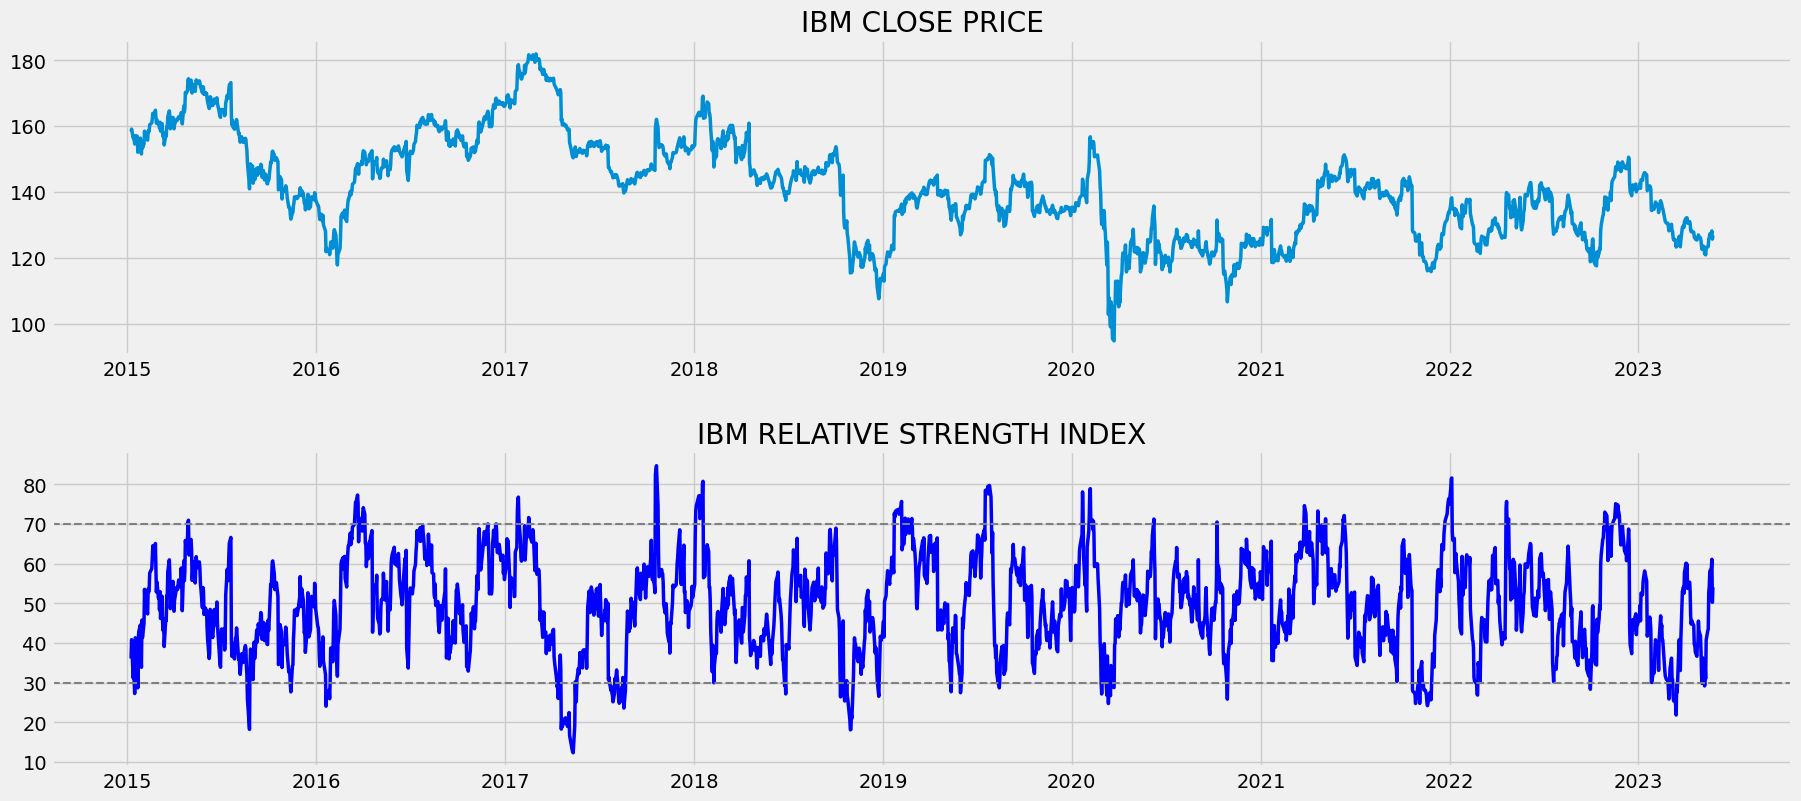

In [6]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(ibm['close'], linewidth = 2.5)
ax1.set_title('IBM CLOSE PRICE')
ax2.plot(ibm['rsi_14'], color = 'blue', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('IBM RELATIVE STRENGTH INDEX')
plt.show()

In [7]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = implement_rsi_strategy(ibm['close'], ibm['rsi_14'])

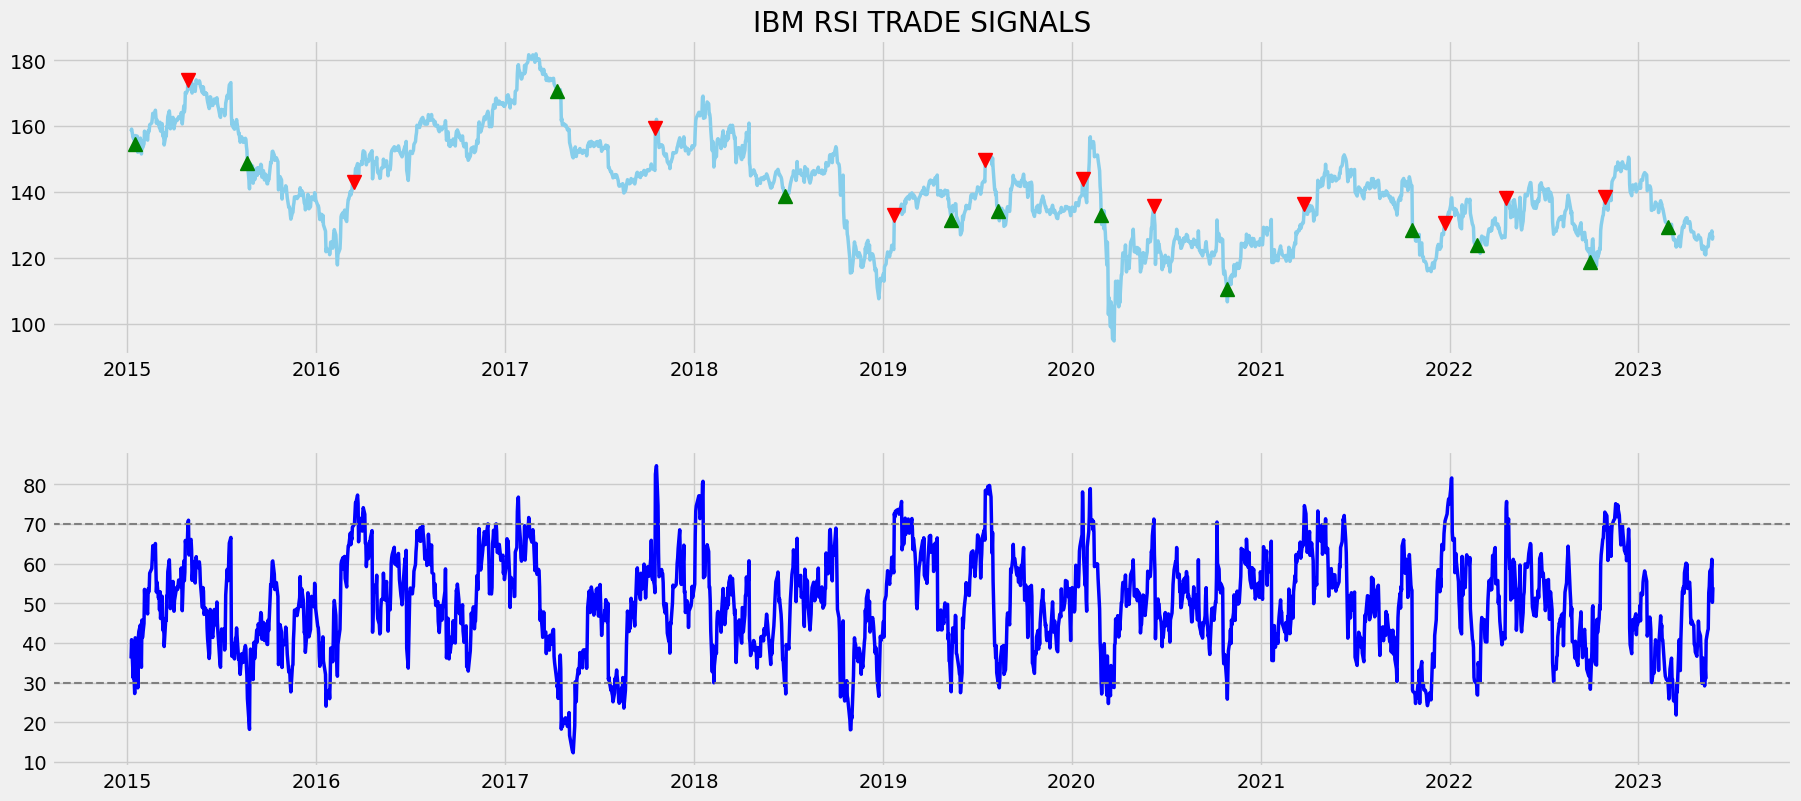

In [8]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(ibm['close'], linewidth = 2.5, color = 'skyblue', label = 'IBM')
ax1.plot(ibm.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(ibm.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('IBM RSI TRADE SIGNALS')
ax2.plot(ibm['rsi_14'], color = 'blue', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

In [9]:
position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(ibm['close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = ibm['rsi_14']
close_price = ibm['close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(ibm.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(ibm.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.head()

,close,rsi_14,rsi_signal,rsi_position
2015-01-08,158.42,36.139650,0,1
2015-01-09,159.11,40.852908,0,1
2015-01-12,156.44,31.243503,0,1
2015-01-13,156.81,33.575236,0,1
2015-01-14,155.80,30.531433,0,1


In [10]:
ibm_ret = pd.DataFrame(np.diff(ibm['close'])).rename(columns = {0:'returns'})
rsi_strategy_ret = []

for i in range(len(ibm_ret)):
    returns = ibm_ret['returns'][i]*strategy['rsi_position'][i]
    rsi_strategy_ret.append(returns)
    
rsi_strategy_ret_df = pd.DataFrame(rsi_strategy_ret).rename(columns = {0:'rsi_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/ibm['close'][-1])
rsi_investment_ret = []

for i in range(len(rsi_strategy_ret_df['rsi_returns'])):
    returns = number_of_stocks*rsi_strategy_ret_df['rsi_returns'][i]
    rsi_investment_ret.append(returns)

rsi_investment_ret_df = pd.DataFrame(rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the RSI strategy by investing $100k in IBM : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the RSI strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the RSI strategy by investing $100k in IBM : 65372.48
Profit percentage of the RSI strategy : 65%


In [11]:
rsi_strategy_ret

[0.6900000000000261,
 -2.670000000000016,
 0.37000000000000455,
 -1.009999999999991,
 -1.2300000000000182,
 2.569999999999993,
 -0.18999999999999773,
 -4.859999999999985,
 3.299999999999983,
 0.4800000000000182,
 0.4900000000000091,
 -2.690000000000026,
 -2.119999999999976,
 3.9299999999999784,
 -2.1699999999999875,
 1.3499999999999943,
 3.8100000000000023,
 -1.509999999999991,
 0.9499999999999886,
 -1.1899999999999977,
 -0.9699999999999989,
 2.8100000000000023,
 -0.36000000000001364,
 0.3200000000000216,
 1.8799999999999955,
 0.5600000000000023,
 1.2299999999999898,
 1.6999999999999886,
 -0.23999999999998067,
 -0.7400000000000091,
 1.920000000000016,
 -2.0200000000000102,
 -1.9399999999999977,
 1.0699999999999932,
 -1.460000000000008,
 0.5500000000000114,
 -1.6100000000000136,
 1.7600000000000193,
 -2.680000000000007,
 2.2700000000000102,
 -2.960000000000008,
 -1.009999999999991,
 1.1799999999999784,
 -3.6999999999999886,
 2.8000000000000114,
 -0.12000000000000455,
 2.8499999999999943

In [12]:
ibm_ret

,returns
0,0.69
1,-2.67
2,0.37
3,-1.01
4,-1.23
...,...
2104,1.11
2105,0.24
2106,0.68
2107,-2.50


In [13]:
rsi_strategy_ret_df

,rsi_returns
0,0.69
1,-2.67
2,0.37
3,-1.01
4,-1.23
...,...
2104,1.11
2105,0.24
2106,0.68
2107,-2.50


In [53]:
rsi_strategy_ret_df['rsi_returns'].cumsum()

0        0.69
1       -1.98
2       -1.61
3       -2.62
4       -3.85
        ...  
2104    83.46
2105    83.70
2106    84.38
2107    81.88
2108    82.96
Name: rsi_returns, Length: 2109, dtype: float64

In [14]:
rsi_investment_ret_df

,investment_returns
0,543.72
1,-2103.96
2,291.56
3,-795.88
4,-969.24
...,...
2104,874.68
2105,189.12
2106,535.84
2107,-1970.00


In [18]:
ibm

,open,high,low,close,adj close,volume,rsi_14
2015-01-08,156.24,159.044,155.55,158.42,104.187135,4240585.0,36.139650
2015-01-09,158.42,160.340,157.25,159.11,104.640923,4472701.0,40.852908
2015-01-12,159.00,159.250,155.76,156.44,102.884960,4187588.0,31.243503
2015-01-13,157.26,159.970,155.68,156.81,103.128296,4386989.0,33.575236
2015-01-14,154.86,156.490,153.74,155.80,102.464055,4689740.0,30.531433
...,...,...,...,...,...,...,...
2023-05-19,126.79,128.290,126.55,127.26,127.260000,4306657.0,58.057184
2023-05-22,127.50,128.190,127.15,127.50,127.500000,2806770.0,58.849015
2023-05-23,127.24,129.090,127.13,128.18,128.180000,4592280.0,61.090390
2023-05-24,127.82,127.900,125.47,125.68,125.680000,3915505.0,50.253261


In [19]:
strategy

,close,rsi_14,rsi_signal,rsi_position
2015-01-08,158.42,36.139650,0,1
2015-01-09,159.11,40.852908,0,1
2015-01-12,156.44,31.243503,0,1
2015-01-13,156.81,33.575236,0,1
2015-01-14,155.80,30.531433,0,1
...,...,...,...,...
2023-05-19,127.26,58.057184,0,1
2023-05-22,127.50,58.849015,0,1
2023-05-23,128.18,61.090390,0,1
2023-05-24,125.68,50.253261,0,1


In [40]:
rsi_strategy_ret

[0.6900000000000261,
 -2.670000000000016,
 0.37000000000000455,
 -1.009999999999991,
 -1.2300000000000182,
 2.569999999999993,
 -0.18999999999999773,
 -4.859999999999985,
 3.299999999999983,
 0.4800000000000182,
 0.4900000000000091,
 -2.690000000000026,
 -2.119999999999976,
 3.9299999999999784,
 -2.1699999999999875,
 1.3499999999999943,
 3.8100000000000023,
 -1.509999999999991,
 0.9499999999999886,
 -1.1899999999999977,
 -0.9699999999999989,
 2.8100000000000023,
 -0.36000000000001364,
 0.3200000000000216,
 1.8799999999999955,
 0.5600000000000023,
 1.2299999999999898,
 1.6999999999999886,
 -0.23999999999998067,
 -0.7400000000000091,
 1.920000000000016,
 -2.0200000000000102,
 -1.9399999999999977,
 1.0699999999999932,
 -1.460000000000008,
 0.5500000000000114,
 -1.6100000000000136,
 1.7600000000000193,
 -2.680000000000007,
 2.2700000000000102,
 -2.960000000000008,
 -1.009999999999991,
 1.1799999999999784,
 -3.6999999999999886,
 2.8000000000000114,
 -0.12000000000000455,
 2.8499999999999943

In [31]:

rsi_strategy_ret_df = pd.DataFrame(rsi_strategy_ret).rename(columns = {0:'rsi_returns'})

In [32]:
rsi_investment_ret_df['investment_returns'] = rsi_investment_ret_df['investment_returns'].shift(1)

In [33]:
rsi_investment_ret_df.iloc[0, 0] = np.nan

In [34]:
rsi_investment_ret_df

,investment_returns
0,NaN
1,NaN
2,543.72
3,-2103.96
4,291.56
...,...
2104,1773.00
2105,346.72
2106,874.68
2107,189.12


In [36]:
# Create the DataFrame
data = {
    'investment_returns': [543.72, -2103.96, 291.56, -795.88, -969.24]
}
df = pd.DataFrame(data)

# Add a null value at the start of the column
df['investment_returns'] = df['investment_returns'].shift(1)


In [37]:
df

,investment_returns
0,NaN
1,543.72
2,-2103.96
3,291.56
4,-795.88


In [38]:
df.iloc[0, 0] = np.nan

In [39]:

# Print the updated DataFrame
print(df)

   investment_returns
0                 NaN
1              543.72
2            -2103.96
3              291.56
4             -795.88


In [28]:
rsi_investment_ret_df.index = strategy.index

ValueError: Length mismatch: Expected axis has 2109 elements, new values have 2110 elements

In [41]:
strategy['daily_return'] = strategy['close'].diff()

In [42]:
strategy

,close,rsi_14,rsi_signal,rsi_position,daily_return
2015-01-08,158.42,36.139650,0,1,NaN
2015-01-09,159.11,40.852908,0,1,0.69
2015-01-12,156.44,31.243503,0,1,-2.67
2015-01-13,156.81,33.575236,0,1,0.37
2015-01-14,155.80,30.531433,0,1,-1.01
...,...,...,...,...,...
2023-05-19,127.26,58.057184,0,1,1.11
2023-05-22,127.50,58.849015,0,1,0.24
2023-05-23,128.18,61.090390,0,1,0.68
2023-05-24,125.68,50.253261,0,1,-2.50


In [ ]:
ibm_ret = pd.DataFrame(np.diff(ibm['close'])).rename(columns = {0:'returns'})
rsi_strategy_ret = []

for i in range(len(ibm_ret)):
    returns = ibm_ret['returns'][i]*strategy['rsi_position'][i]
    rsi_strategy_ret.append(returns)
    
rsi_strategy_ret_df = pd.DataFrame(rsi_strategy_ret).rename(columns = {0:'rsi_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/ibm['close'][-1])
rsi_investment_ret = []

for i in range(len(rsi_strategy_ret_df['rsi_returns'])):
    returns = number_of_stocks*rsi_strategy_ret_df['rsi_returns'][i]
    rsi_investment_ret.append(returns)

rsi_investment_ret_df = pd.DataFrame(rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the RSI strategy by investing $100k in IBM : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the RSI strategy : {}%'.format(profit_percentage), attrs = ['bold']))

In [43]:
strategy['rsi_strategy_ret'] = np.nan
strategy

,close,rsi_14,rsi_signal,rsi_position,daily_return,rsi_strategy_ret
2015-01-08,158.42,36.139650,0,1,NaN,NaN
2015-01-09,159.11,40.852908,0,1,0.69,NaN
2015-01-12,156.44,31.243503,0,1,-2.67,NaN
2015-01-13,156.81,33.575236,0,1,0.37,NaN
2015-01-14,155.80,30.531433,0,1,-1.01,NaN
...,...,...,...,...,...,...
2023-05-19,127.26,58.057184,0,1,1.11,NaN
2023-05-22,127.50,58.849015,0,1,0.24,NaN
2023-05-23,128.18,61.090390,0,1,0.68,NaN
2023-05-24,125.68,50.253261,0,1,-2.50,NaN


In [54]:

for i in range(1,len(strategy)):
    strategy['rsi_strategy_ret'][i] = strategy['daily_return'][i]*strategy['rsi_position'][i-1]

C:\Users\hp\AppData\Local\Temp\ipykernel_11952\3129954452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strategy['rsi_strategy_ret'][i] = strategy['daily_return'][i]*strategy['rsi_position'][i-1]


In [55]:
strategy

,close,rsi_14,rsi_signal,rsi_position,daily_return,rsi_strategy_ret,cumm_rsi_strategy_ret
2015-01-08,158.42,36.139650,0,1,NaN,NaN,NaN
2015-01-09,159.11,40.852908,0,1,0.69,0.69,0.69
2015-01-12,156.44,31.243503,0,1,-2.67,-2.67,-1.98
2015-01-13,156.81,33.575236,0,1,0.37,0.37,-1.61
2015-01-14,155.80,30.531433,0,1,-1.01,-1.01,-2.62
...,...,...,...,...,...,...,...
2023-05-19,127.26,58.057184,0,1,1.11,1.11,-14.48
2023-05-22,127.50,58.849015,0,1,0.24,0.24,-14.24
2023-05-23,128.18,61.090390,0,1,0.68,0.68,-13.56
2023-05-24,125.68,50.253261,0,1,-2.50,-2.50,-16.06


In [57]:
strategy['cumm_rsi_strategy_ret'] = strategy['rsi_strategy_ret'].cumsum()

In [58]:
strategy

,close,rsi_14,rsi_signal,rsi_position,daily_return,rsi_strategy_ret,cumm_rsi_strategy_ret
2015-01-08,158.42,36.139650,0,1,NaN,NaN,NaN
2015-01-09,159.11,40.852908,0,1,0.69,0.69,0.69
2015-01-12,156.44,31.243503,0,1,-2.67,-2.67,-1.98
2015-01-13,156.81,33.575236,0,1,0.37,0.37,-1.61
2015-01-14,155.80,30.531433,0,1,-1.01,-1.01,-2.62
...,...,...,...,...,...,...,...
2023-05-19,127.26,58.057184,0,1,1.11,1.11,83.46
2023-05-22,127.50,58.849015,0,1,0.24,0.24,83.70
2023-05-23,128.18,61.090390,0,1,0.68,0.68,84.38
2023-05-24,125.68,50.253261,0,1,-2.50,-2.50,81.88


In [56]:
strategy['rsi_strategy_ret'].cumsum()

2015-01-08      NaN
2015-01-09     0.69
2015-01-12    -1.98
2015-01-13    -1.61
2015-01-14    -2.62
              ...  
2023-05-19    83.46
2023-05-22    83.70
2023-05-23    84.38
2023-05-24    81.88
2023-05-25    82.96
Name: rsi_strategy_ret, Length: 2110, dtype: float64

In [59]:
investment_value = 100000
number_of_stocks = floor(investment_value/ibm['close'][-1])

strategy['rsi_investment_ret'] = np.nan

for i in range(len(strategy)):
    strategy['rsi_investment_ret'][i] = number_of_stocks*strategy['rsi_strategy_ret'][i]

C:\Users\hp\AppData\Local\Temp\ipykernel_11952\1878470567.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strategy['rsi_investment_ret'][i] = number_of_stocks*strategy['rsi_strategy_ret'][i]


In [60]:
strategy

,close,rsi_14,rsi_signal,rsi_position,daily_return,rsi_strategy_ret,cumm_rsi_strategy_ret,rsi_investment_ret
2015-01-08,158.42,36.139650,0,1,NaN,NaN,NaN,NaN
2015-01-09,159.11,40.852908,0,1,0.69,0.69,0.69,543.72
2015-01-12,156.44,31.243503,0,1,-2.67,-2.67,-1.98,-2103.96
2015-01-13,156.81,33.575236,0,1,0.37,0.37,-1.61,291.56
2015-01-14,155.80,30.531433,0,1,-1.01,-1.01,-2.62,-795.88
...,...,...,...,...,...,...,...,...
2023-05-19,127.26,58.057184,0,1,1.11,1.11,83.46,874.68
2023-05-22,127.50,58.849015,0,1,0.24,0.24,83.70,189.12
2023-05-23,128.18,61.090390,0,1,0.68,0.68,84.38,535.84
2023-05-24,125.68,50.253261,0,1,-2.50,-2.50,81.88,-1970.00


In [61]:
strategy['cum_rsi_investment_ret'] = strategy['rsi_investment_ret'].cumsum()

In [62]:
strategy

,close,rsi_14,rsi_signal,rsi_position,daily_return,rsi_strategy_ret,cumm_rsi_strategy_ret,rsi_investment_ret,cum_rsi_investment_ret
2015-01-08,158.42,36.139650,0,1,NaN,NaN,NaN,NaN,NaN
2015-01-09,159.11,40.852908,0,1,0.69,0.69,0.69,543.72,543.72
2015-01-12,156.44,31.243503,0,1,-2.67,-2.67,-1.98,-2103.96,-1560.24
2015-01-13,156.81,33.575236,0,1,0.37,0.37,-1.61,291.56,-1268.68
2015-01-14,155.80,30.531433,0,1,-1.01,-1.01,-2.62,-795.88,-2064.56
...,...,...,...,...,...,...,...,...,...
2023-05-19,127.26,58.057184,0,1,1.11,1.11,83.46,874.68,65766.48
2023-05-22,127.50,58.849015,0,1,0.24,0.24,83.70,189.12,65955.60
2023-05-23,128.18,61.090390,0,1,0.68,0.68,84.38,535.84,66491.44
2023-05-24,125.68,50.253261,0,1,-2.50,-2.50,81.88,-1970.00,64521.44


In [65]:
stats = strategy['rsi_investment_ret'].calc_stats()
stats.display()

Stats for rsi_investment_ret from 2015-01-08 00:00:00 - 2023-05-25 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return    Sharpe    CAGR    Max Drawdown
--------------  --------  ------  --------------
-               -         5.50%   -486.96%

Annualized Returns:
mtd       3m     6m     ytd    1y    3y       5y    10y    incep.
--------  -----  -----  -----  ----  -------  ----  -----  --------
-292.86%  -inf%  -inf%  -inf%  inf%  -31.61%  inf%  -      5.50%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  -        -          -
mean    -        -          -inf%
vol     -        -          -
skew    -        -          -
kurt    -        -          -
best    inf%     inf%       92.19%
worst   -inf%    -inf%      -inf%

Drawdowns:
max       avg         # days
--------  --------  --------
-486.96%  -256.26%    380.62

Misc:
---------------  ------
avg. up month    inf%
avg. down month  -inf%
up year %        25.00%
12m up %   

C:\Users\hp\anaconda3\lib\site-packages\ffn\core.py:1293: RuntimeWarning: divide by zero encountered in double_scalars
  return daily_prices[-1] / yearly_prices[-2] - 1
C:\Users\hp\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\hp\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\hp\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\hp\anaconda3\lib\site-packages\ffn\core.py:339: RuntimeWarning: divide by zero encountered in double_scalars
  self.three_month = dp[-1] / denom[-1] - 1
C:\Users\hp\anaconda3\lib\site-packages\ffn\core.py:358: RuntimeWarning: divide by zero encountered in double_scalars
  self.six_month = dp[-1]

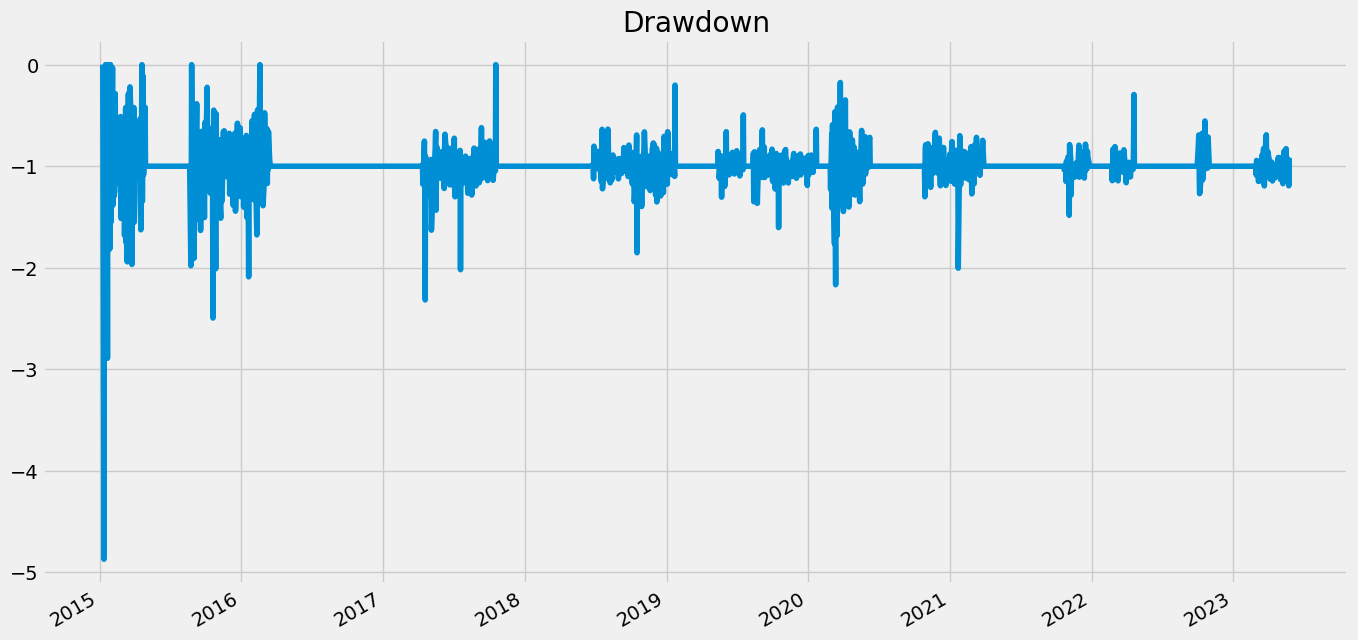

In [79]:
ax = stats.prices.to_drawdown_series().plot(figsize=(15, 8),title='Drawdown')

<AxesSubplot:title={'center':'rsi_investment_ret Price Series'}>

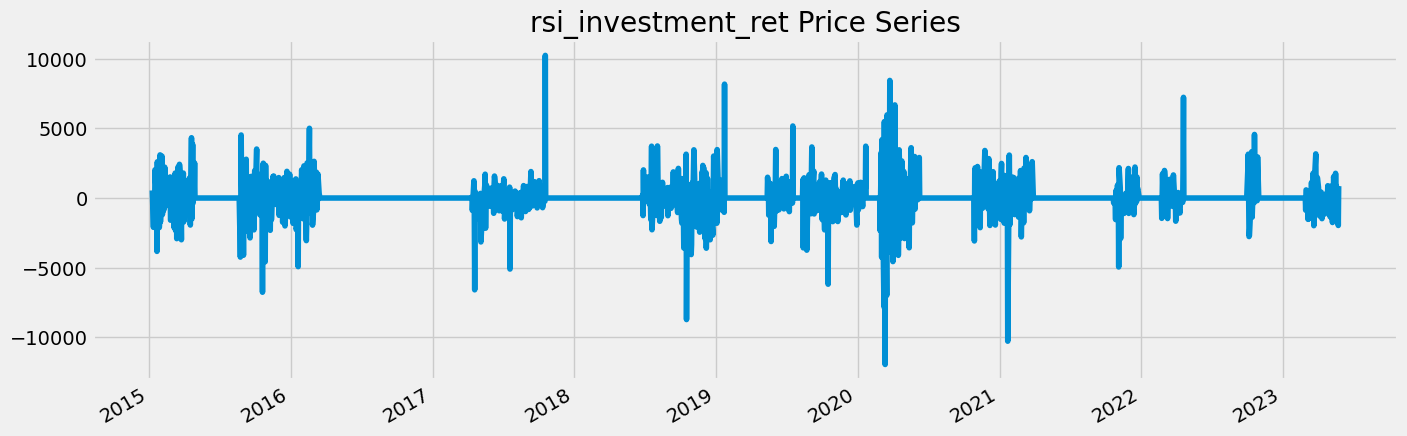

In [80]:
stats.plot()

In [75]:
type(stats)

ffn.core.PerformanceStats

In [77]:
stats

In [82]:
stats = strategy['cum_rsi_investment_ret'].calc_stats()
stats.display()

Stats for cum_rsi_investment_ret from 2015-01-08 00:00:00 - 2023-05-25 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
-                   0.33  77.19%  -1095.65%

Annualized Returns:
mtd    3m      6m      ytd     1y      3y       5y    10y    incep.
-----  ------  ------  ------  ------  -------  ----  -----  --------
0.42%  -2.97%  -2.97%  -2.97%  26.08%  107.71%  -     -      77.19%

Periodic:
        daily      monthly    yearly
------  ---------  ---------  --------
sharpe  0.33       -0.41      0.40
mean    589.61%    -350.06%   246.02%
vol     1799.18%   849.47%    618.69%
skew    0.45       -1.63      2.60
kurt    468.03     17.07      7.01
best    2837.50%   1126.47%   1744.44%
worst   -3020.00%  -1363.95%  -140.62%

Drawdowns:
max        avg        # days
---------  -------  --------
-1095.65%  -60.83%     65.24

Misc:
---------------  -------
avg. up month    114.65%
av

C:\Users\hp\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\hp\anaconda3\lib\site-packages\ffn\core.py:1376: RuntimeWarning: invalid value encountered in double_scalars
  return (prices.iloc[-1] / prices.iloc[0]) ** (1 / year_frac(start, end)) - 1


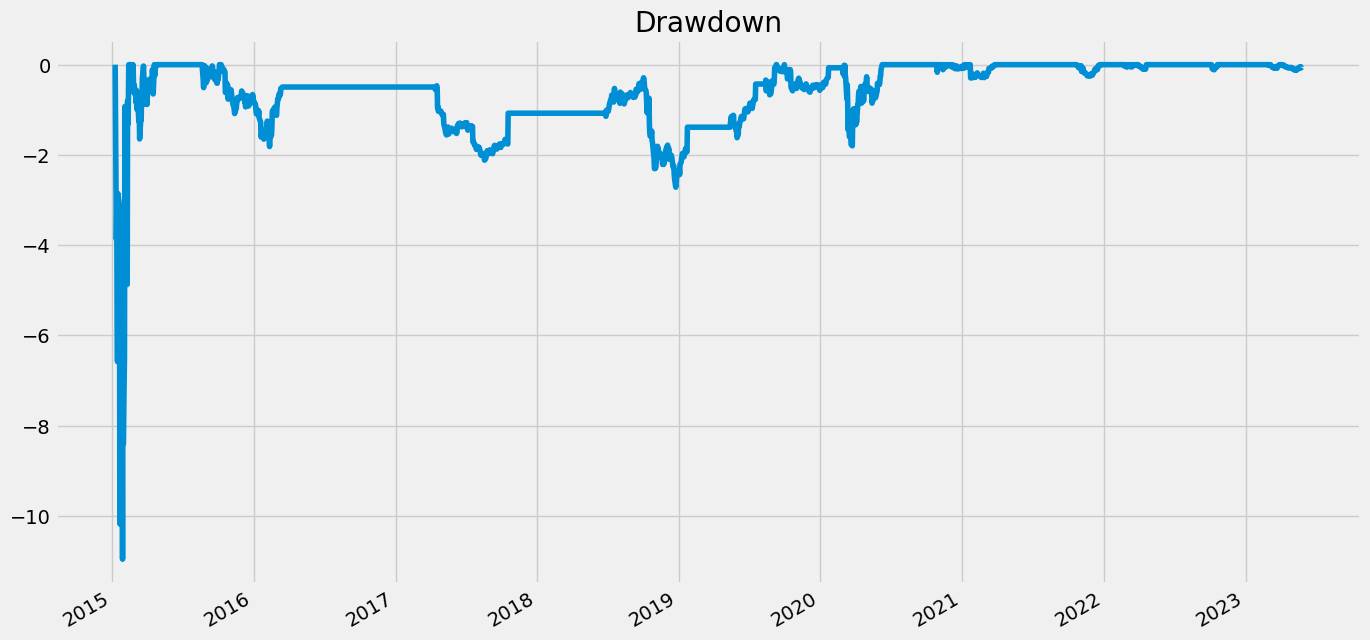

In [83]:
ax = stats.prices.to_drawdown_series().plot(figsize=(15, 8),title='Drawdown')

<AxesSubplot:title={'center':'cum_rsi_investment_ret Price Series'}>

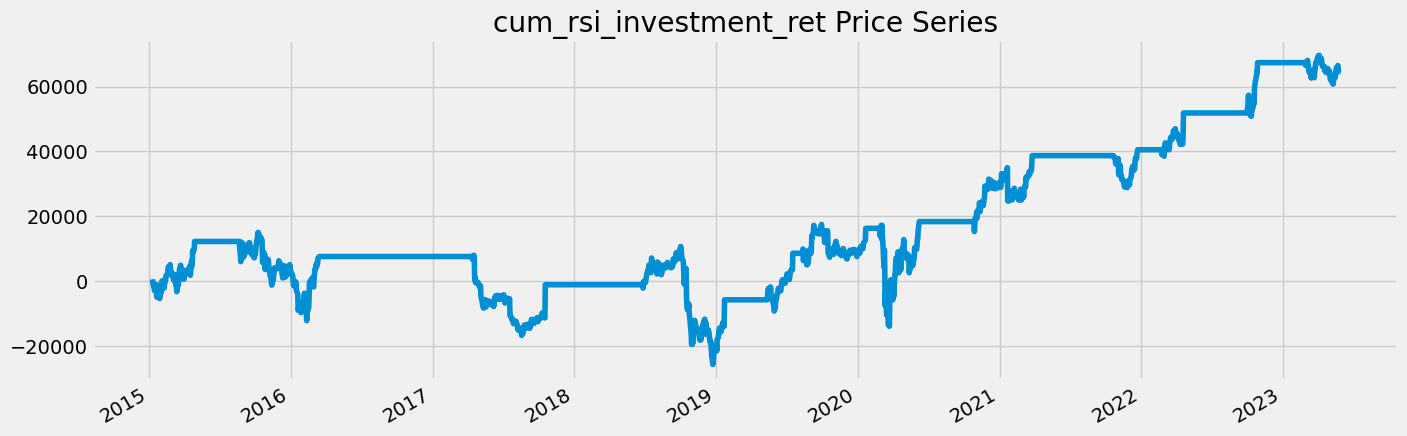

In [84]:
stats.plot()